# Clustering All Groups Users

Cluster symptoms from the users meeting the criteria for menopause.

User selection criteria - users have recorded more than 0 days of symptoms, that they've entered menopause, that they don't have periods anymore, and that they've not had chemo. 

## Notebook Setup

In [79]:
import pandas as pd
import numpy as np
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
from sensorfabric.athena import athena

In [3]:
# Establish connection with the database using PyAthena.
cursor = connect(s3_staging_dir='s3://menolife-opensci/athena/',
                  schema_name='menolife',
                  cursor_class=PandasCursor,
                  work_group='amyris',
                  region_name='us-east-1'
                ).cursor()

env: AWS_PROFILE=opensci


In [5]:
db = athena(database='menolife', workgroup='amyris', offlineCache=True)

In [6]:
# Color and Font setup for using seaborn.

sns.set_palette('coolwarm')
sns.color_palette()

[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.603162067917647, 0.7315274773529412, 0.9995652785372549),
 (0.7867207013568628, 0.8448072103686275, 0.9398103849490196),
 (0.9306685963333333, 0.818876999654902, 0.7591463906980392),
 (0.9673165156666667, 0.6574708288078431, 0.5381601507294118),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

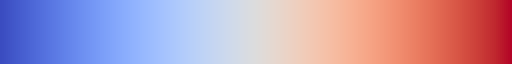

In [7]:
sns.color_palette('coolwarm', as_cmap=True)

In [8]:
# Get the colors from a Seaborn palette in RGB format
rgb_colors = sns.color_palette('coolwarm',6).as_hex()

# Display the names of the colors in RGB format
for i, color in enumerate(rgb_colors):
    print(f"Color {i + 1}: {color}")

Color 1: #6788ee
Color 2: #9abbff
Color 3: #c9d7f0
Color 4: #edd1c2
Color 5: #f7a889
Color 6: #e26952


* Premenopause - #e26952
* Perimenopause - #edd1c2
* Menopause -#e26952

In [9]:
# Set the font for all the graphs to Arial.
plt.rcParams['font.family'] = ['sans serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12

## Dataset creation all Perimenopause aka "Unpredictable Cycles w/ VMS" (unpredictablewvms)

In [10]:
#start with filtering out menopausal users using a premenopausal query. Then you'll filter only for those with VMS and who have unpredictable periods
premenopausalusers_symptoms_query = """

WITH query1 AS (

    SELECT DISTINCT healthid
    FROM onboardingpp o
    WHERE (questions = 'How would you describe your periods?')
        AND length(answers) > 0
        AND answers NOT LIKE '%have a period anymore%'
        AND answers NOT LIKE '%take birth control%'
),

query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid,days_symptoms_recorded,symptoms_recorded 
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
       
        AND ss.uid IN (SELECT DISTINCT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;
"""

premenopausalusers_symptoms = db.execQuery(premenopausalusers_symptoms_query, cached=True)
print(premenopausalusers_symptoms.shape)

(40664, 3)


In [11]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(premenopausalusers_symptoms['uid'].values, premenopausalusers_symptoms['name'].values, premenopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)
frame=frame.astype(int)

In [12]:
special = frame[(frame['hot_flashes'] > 0) | (frame['night_sweats'] > 0)]

In [13]:
import utils
unpredictable_uids = db.execQuery('select uid from premeno_period_unpredictable', cached=True) #ok i guess we had a table called that already...convenient

In [14]:
unpredictablewvms = special[special.index.isin(unpredictable_uids['uid'].values)]

perimenopauseframe=unpredictablewvms

In [15]:
#Let's Identify the number of UIDs in each group

#Now how many do I have who are unpredictable with VMS
unique_uids = unpredictablewvms.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of Unpredictable with Vasomotor Symptoms:", unique_uids_size)


Size of Unpredictable with Vasomotor Symptoms: 1388


In [16]:
#Save out the perimenopausal group symptoms

#unpredictablewvms.to_csv('perimenopausal_npt_symptoms.csv')

## Dataset creation all Premenopause premenopauseframe

In [17]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(premenopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 3052


In [18]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(premenopausalusers_symptoms['uid'].values, premenopausalusers_symptoms['name'].values, premenopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

frame=frame.astype(int)


In [19]:
#Note some users are still reporting hot flashes. Remove them. 

frame = frame[(frame['hot_flashes'] == 0) & (frame['night_sweats'] == 0)]

In [20]:
#Now how many do I have left?

unique_uids = frame.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 1115


In [21]:
premenopauseframe=frame

## Dataset creation All Menopause menopauseframe

In [22]:
# Get all the symptoms.
symptoms = db.execQuery("select distinct(name) name from symptoms order by name asc", cached=True)
print(symptoms.shape)

(45, 1)


In [23]:
# Create an empty list for all the columns which are going to be the individual symptoms.
symptoms = symptoms['name'].values

### Create a much simpler query based on answer to how did you enter menopause:this checks for if you report having entered menopause and if you report no periods in at least 12 months - Draw from symptompp_npt or symptompp_pot to get non product takers or product takers. Elsewise symptoms is all symptoms, symptompp removes some test users

In [24]:
menopausalusers_symptoms_query = """
WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
        
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)
SELECT q2.uid, q2.name, q2.count
FROM query2 q2
ORDER BY q2.uid, q2.count DESC;

"""

menopausalusers_symptoms = db.execQuery(menopausalusers_symptoms_query, cached=True)
print(menopausalusers_symptoms.shape)
menopausalusers_symptoms.head()

(33945, 3)


uid             name  count
0  5f92aeffa42cd9d7053ec1ff          anxiety      2
1  5f92aeffa42cd9d7053ec1ff          fatigue      2
2  5f92aeffa42cd9d7053ec1ff  vaginal_dryness      2
3  5f92aeffa42cd9d7053ec1ff         spotting      2
4  5f92aeffa42cd9d7053ec1ff        sex_drive      2

### Check the onboarding data of who actually showed up in the query

In [25]:
menopausalusers_onboarding_query = """

WITH query1 AS (
    SELECT DISTINCT healthid
    FROM onboardingpp 
    WHERE (questions = 'How did you enter menopause?'
    OR questions = 'How would you describe your menstrual cycle?')
        AND length(answers) > 1
        AND (answers LIKE '%Naturally%'
                OR answers LIKE '%Medically%'
                OR answers LIKE '%Hysterectomy%'
                or answers LIKE '%have a period%'
                or answers LIKE '%12 months%')
        AND (answers NOT LIKE '%Chemotherapy%')
),
query2 AS (
    SELECT s.uid, s.name, COUNT(s.name) AS count 
    FROM symptompp_npt s
    INNER JOIN query1 q1 ON s.uid = q1.healthid
    INNER JOIN (
        SELECT uid
        FROM symptoms_sum ss
        WHERE days_symptoms_recorded > 0
        and symptoms_recorded >10
        and symptoms_recorded <300
        AND ss.uid IN (SELECT healthid FROM query1)
    ) ss ON q1.healthid = ss.uid
    GROUP BY s.uid, s.name
)

SELECT q2.uid, o.questions, o.answers
FROM query2 q2
INNER JOIN onboardingpp o ON q2.uid = o.healthid
ORDER BY q2.uid, o.questions, q2.count DESC;

   

"""

menopausalusers_onboarding = db.execQuery(menopausalusers_onboarding_query, cached=True)
print(menopausalusers_onboarding.shape)

(151306, 3)


In [26]:
menopausalusers_onboarding.to_csv('onboarding_menopausalnpt_check.csv')

In [27]:
#Is this still keeping only the correct uids? 

# Calculate the unique number of UIDs
unique_uids_count = len(menopausalusers_symptoms['uid'].unique())

# Display the unique number of UIDs
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 2403


### Create Dataframe of Queried Data and Plot Symptom Frequencies

In [28]:
frame = pd.DataFrame()  # Empty dataframe that will contain all the dataset.
uidmap = {}
# Start breaking the users frame and extract data from it to add to the data matrix.
temp = None  # Temp dictionary that holds the symptom counts for each user.
for uid, sname, scount in zip(menopausalusers_symptoms['uid'].values, menopausalusers_symptoms['name'].values, menopausalusers_symptoms['count'].values):
    if not (uid in uidmap):
        # If temp is not None (everything except for the first uid then we will concat the last uid to the frame.
        if not (temp is None):
            temp = pd.Series(temp)
            temp = temp.to_frame().T
            frame = pd.concat([frame, temp], ignore_index=True)
        temp = {}  # Start fresh again.
        temp['uid'] = uid
        uidmap[uid] = 1
    temp[sname] = scount
frame = frame.set_index(['uid']) # Set the 'uid' as the index, so it becomes easier to query.
frame = frame.fillna(0)

In [29]:
#Note some users are still reporting ovulation and ovulation pain. Remove them 

frame = frame[(frame['ovulation'] == 0) & (frame['ovulation_pain'] == 0)]

In [30]:
#Now how many do I have left?

unique_uids = frame.index.unique().tolist()
unique_uids_size = len(unique_uids)
print("Size of unique_uids:", unique_uids_size)

Size of unique_uids: 2286


In [31]:
# Calculate the unique number of UIDs before I got rid of people who report ovulation

unique_uids_count = len(menopausalusers_symptoms['uid'].unique())
print("Unique number of UIDs:", unique_uids_count)

Unique number of UIDs: 2403


In [32]:
#frame.to_csv('menopausalsymptomsnonpttest.csv')

In [33]:
frame.head()

anxiety  fatigue  vaginal_dryness  spotting  \
uid                                                                     
5f92aeffa42cd9d7053ec1ff        2        2                2         2   
5f982c6344eca8ead4eca0c1        0        0                0         0   
5f98e88b44eca8ead4eca24c        0        1                0         0   
5f9935fa44eca8ead4eca26d        0        0                1         0   
5f99b73cb82e4d12e4a90a4d        1        0                0         0   

                          sex_drive  night_sweats  mood_swings  hot_flashes  \
uid                                                                           
5f92aeffa42cd9d7053ec1ff          2             2            2            2   
5f982c6344eca8ead4eca0c1          0             0            1           29   
5f98e88b44eca8ead4eca24c          0             1            0           83   
5f9935fa44eca8ead4eca26d          1             0            2            0   
5f99b73cb82e4d12e4a90a4d          1             1            1            1   

                          headaches  painful_intercourse  ...  \
uid                                                       ...   
5f92aeffa42cd9d7053ec1ff          2                    2  ...   
5f982c6344eca8ead4eca0c1          0                    0  ...   
5f98e88b44eca8ead4eca24c          0                    0  ...   
5f9935fa44eca8ead4eca26d          1                    0  ...   
5f99b73cb82e4d12e4a90a4d          1                    0  ...   

                          tingling_extremeties  yeast_infection  cramps  \
uid                                                                       
5f92aeffa42cd9d7053ec1ff                     0                0       0   
5f982c6344eca8ead4eca0c1                     0                0       0   
5f98e88b44eca8ead4eca24c                     0                0       0   
5f9935fa44eca8ead4eca26d                     0                0       0   
5f99b73cb82e4d12e4a90a4d                     0                0       0   

                          depression  breast_swelling  vertigo  odor  \
uid                                                                    
5f92aeffa42cd9d7053ec1ff           0                0        0     0   
5f982c6344eca8ead4eca0c1           0                0        0     0   
5f98e88b44eca8ead4eca24c           0                0        0     0   
5f9935fa44eca8ead4eca26d           0                0        0     0   
5f99b73cb82e4d12e4a90a4d           0                0        0     0   

                          incontinence  diarrhea  vomiting  
uid                                                         
5f92aeffa42cd9d7053ec1ff             0         0         0  
5f982c6344eca8ead4eca0c1             0         0         0  
5f98e88b44eca8ead4eca24c             0         0         0  
5f9935fa44eca8ead4eca26d             0         0         0  
5f99b73cb82e4d12e4a90a4d             0         0         0  

[5 rows x 45 columns]

In [34]:
frame=frame.astype(int)

In [35]:
data_type = frame[symptoms].dtypes

In [36]:
menopauseframe=frame

In [37]:
#encoding = frame.copy(deep=True)

In [38]:
#encoding

In [39]:
#def replace_map(x):
#    if x > 0:
#        return 1
#    else:
#        return 0

In [40]:
#encoding = encoding.applymap(replace_map)

In [41]:
# Save this into a csv file so we can use it from inside R.
#encoding.to_csv('symptoms_menopause_npt_onehot.csv', index=False)

## Visualize and Compare Symptom Distributions

In [42]:
#How Many Total Symptoms, Plot Common Symptoms by Count and by % User
# How many total symptoms

total_symptom_count_premenopause = premenopauseframe.sum().sum()
print("Total count of all premenopausal symptoms:", total_symptom_count_premenopause)

total_symptom_count_perimenopause = unpredictablewvms.sum().sum()
print("Total count of all perimenopausal symptoms:", total_symptom_count_perimenopause)

total_symptom_count_menopause = menopauseframe.sum().sum()
print("Total count of all menopausal symptoms:", total_symptom_count_menopause)


Total count of all premenopausal symptoms: 27731
Total count of all perimenopausal symptoms: 57964
Total count of all menopausal symptoms: 61806


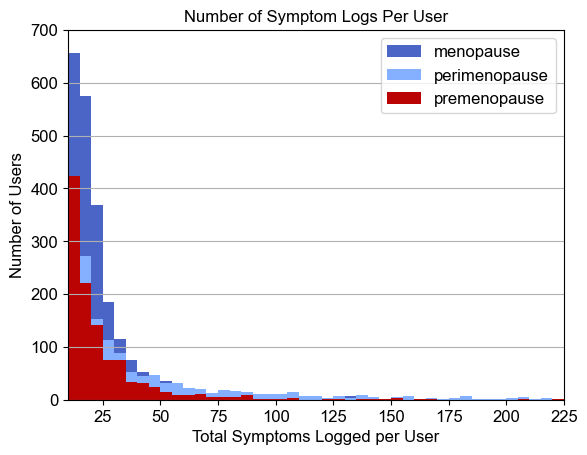

In [43]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming you already have the 'frame' dataframe with symptom counts

## For Premenopause

# Total symptom count for each UID
total_symptom_count_per_uid_premenopause = premenopauseframe.sum(axis=1)
# Calculate the total symptoms per user
total_symptoms_per_user_premenopause = total_symptom_count_per_uid_premenopause.values
# Calculate the median and median absolute deviation
median_symptoms_per_user_premenopause = np.median(total_symptoms_per_user_premenopause)
mad_symptoms_per_user_premenopause = np.median(np.abs(total_symptoms_per_user_premenopause - median_symptoms_per_user_premenopause))


## For Perimenopause

# Total symptom count for each UID
total_symptom_count_per_uid_perimenopause = perimenopauseframe.sum(axis=1)
# Calculate the total symptoms per user
total_symptoms_per_user_perimenopause = total_symptom_count_per_uid_perimenopause.values
# Calculate the median and median absolute deviation
median_symptoms_per_user_perimenopause = np.median(total_symptoms_per_user_perimenopause)
mad_symptoms_per_user_perimenopause = np.median(np.abs(total_symptoms_per_user_perimenopause - median_symptoms_per_user_perimenopause))


# For menopause

# Total symptom count for each UID
total_symptom_count_per_uid_menopause = menopauseframe.sum(axis=1)
# Calculate the total symptoms per user
total_symptoms_per_user_menopause = total_symptom_count_per_uid_menopause.values
# Calculate the median and median absolute deviation
median_symptoms_per_user_menopause = np.median(total_symptoms_per_user_menopause)
mad_symptoms_per_user_menopause = np.median(np.abs(total_symptoms_per_user_menopause - median_symptoms_per_user_menopause))

# New colors

#Color 1: #8db0fe
#Color 2: #dddcdc
#Color 3: #f4987a
color_premenopause = '#ba0404' 
color_perimenopause = '#85afff'  
color_menopause = '#1d3fb8'  

# Create histogram with specified bins
bins = range(0, max(total_symptoms_per_user_premenopause) + 5, 5)

plt.hist(total_symptoms_per_user_menopause, bins=bins, edgecolor='none',  
         alpha=0.8, color=color_menopause, label='menopause')

plt.hist(total_symptoms_per_user_perimenopause, bins=bins, edgecolor='none',  
         alpha=1, color=color_perimenopause, label='perimenopause')

plt.hist(total_symptoms_per_user_premenopause, bins=bins, 
         edgecolor='none', alpha=1, color=color_premenopause, label='premenopause')

plt.xlabel('Total Symptoms Logged per User')
plt.ylabel('Number of Users')
plt.title('Number of Symptom Logs Per User')
plt.grid(axis='y')
plt.ylim(0, 700)  # note it goes up to about 2500
plt.xlim(10, 225)  # note some rando users log >500 symptoms. Should we omit them?
plt.legend()
plt.savefig('paper_figures/symptom_log_per_user.png')
plt.show()

In [44]:
# Premenopause Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = premenopauseframe.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages_premenopause = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages_premenopause.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

fatigue: 7.94%
spotting: 7.44%
cramps: 6.65%
bloating: 6.16%
headaches: 5.78%
anxiety: 5.02%
breast_pain: 4.23%
brain_fog: 3.79%
joint_pain: 3.60%
allergies: 3.34%
mood_swings: 3.10%
dry_skin: 3.02%
muscle_tension: 2.88%
depression: 2.66%
itchy_skin: 2.49%
insomnia: 2.23%
dry_eyes: 2.12%
constipation: 1.94%
ringing_ears: 1.85%
dizzy: 1.79%
hair_loss: 1.76%
facial_hair: 1.69%
brittle_nails: 1.67%
sex_drive: 1.67%
memory_lapse: 1.66%
breast_swelling: 1.51%
diarrhea: 1.28%
tingling_extremeties: 1.23%
nausea: 1.21%
incontinence: 1.12%
irregular_beat: 1.05%
heartburn: 0.91%
chills: 0.88%
odor: 0.86%
ovulation_pain: 0.75%
vaginal_dryness: 0.74%
vertigo: 0.58%
ovulation: 0.58%
uti: 0.23%
yeast_infection: 0.21%
painful_intercourse: 0.17%
vomiting: 0.12%
nipple_discharge: 0.08%
hot_flashes: 0.00%
night_sweats: 0.00%


In [45]:
# Perimenopause Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = perimenopauseframe.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages_perimenopause = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages_perimenopause.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

hot_flashes: 14.78%
fatigue: 6.33%
headaches: 4.77%
night_sweats: 4.77%
cramps: 4.38%
bloating: 4.26%
anxiety: 4.15%
joint_pain: 3.36%
spotting: 3.26%
brain_fog: 3.02%
muscle_tension: 3.02%
mood_swings: 2.74%
allergies: 2.58%
breast_pain: 2.49%
dry_skin: 2.49%
insomnia: 2.46%
depression: 2.28%
dry_eyes: 2.05%
itchy_skin: 2.04%
dizzy: 1.73%
facial_hair: 1.54%
brittle_nails: 1.51%
chills: 1.39%
incontinence: 1.34%
nausea: 1.33%
hair_loss: 1.32%
sex_drive: 1.32%
memory_lapse: 1.31%
ringing_ears: 1.31%
diarrhea: 1.29%
constipation: 1.25%
tingling_extremeties: 1.22%
heartburn: 1.07%
irregular_beat: 1.04%
odor: 0.93%
breast_swelling: 0.92%
vaginal_dryness: 0.80%
ovulation_pain: 0.52%
vertigo: 0.46%
vomiting: 0.25%
yeast_infection: 0.23%
painful_intercourse: 0.22%
uti: 0.20%
ovulation: 0.17%
nipple_discharge: 0.10%


In [46]:
# menopause Symptom Frequency by % of total symptoms, for each symptom

# Step 1: Calculate the total count of each symptom type (sum across columns)
symptom_totals = menopauseframe.sum(axis=0)

# Step 2: Calculate the total count of all symptoms
total_symptom_count = symptom_totals.sum()

# Step 3: Calculate the percentage of each symptom type's count relative to the total count of all symptoms
symptom_percentages_menopause = (symptom_totals / total_symptom_count) * 100

# Step 4: Sort the symptom_percentages in descending order (most frequent to least frequent)
symptom_percentages_sorted = symptom_percentages_menopause.sort_values(ascending=False)

# Step 5: Print out each symptom type and its corresponding percentage in the sorted order
for symptom, count in zip(symptom_percentages_sorted.index, symptom_percentages_sorted.values):
   print(f"{symptom}: {count:.2f}%")

hot_flashes: 22.25%
fatigue: 5.13%
night_sweats: 4.31%
anxiety: 3.96%
joint_pain: 3.52%
bloating: 3.45%
brain_fog: 3.42%
headaches: 3.07%
insomnia: 2.93%
dry_skin: 2.85%
mood_swings: 2.70%
depression: 2.63%
allergies: 2.53%
dry_eyes: 2.43%
muscle_tension: 2.41%
brittle_nails: 2.21%
itchy_skin: 2.12%
facial_hair: 2.10%
sex_drive: 2.08%
memory_lapse: 2.04%
hair_loss: 1.72%
constipation: 1.66%
ringing_ears: 1.48%
dizzy: 1.47%
tingling_extremeties: 1.47%
vaginal_dryness: 1.45%
incontinence: 1.41%
chills: 1.36%
heartburn: 1.27%
breast_pain: 1.07%
nausea: 1.03%
irregular_beat: 1.02%
odor: 0.87%
cramps: 0.86%
diarrhea: 0.83%
painful_intercourse: 0.68%
vertigo: 0.59%
breast_swelling: 0.48%
uti: 0.37%
spotting: 0.36%
yeast_infection: 0.24%
vomiting: 0.10%
nipple_discharge: 0.09%
ovulation_pain: 0.00%
ovulation: 0.00%


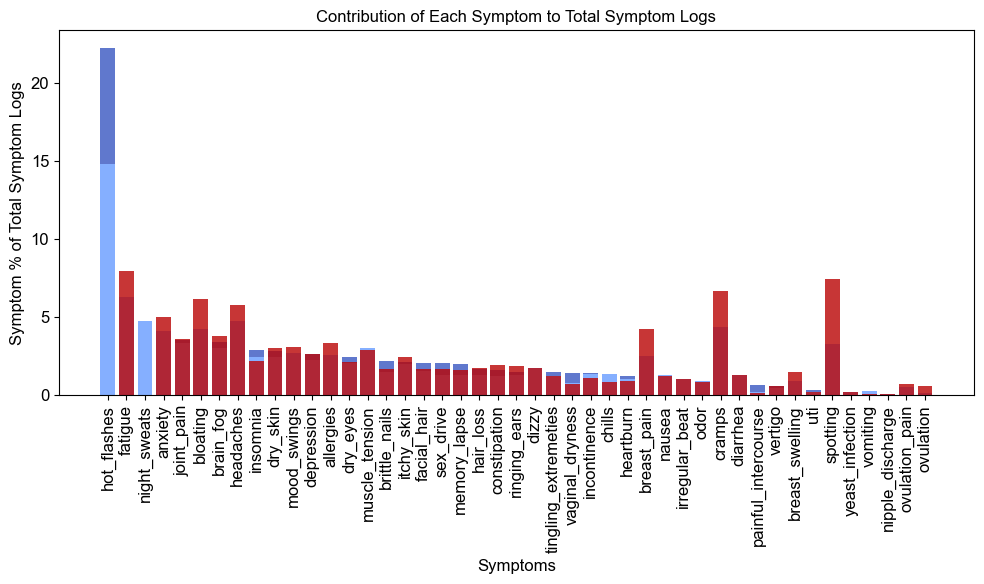

In [47]:
symptom_percentages_sorted_premenopause = symptom_percentages_premenopause.sort_values(ascending=False)
symptom_percentages_sorted_perimenopause = symptom_percentages_perimenopause.sort_values(ascending=False)
symptom_percentages_sorted_menopause = symptom_percentages_menopause.sort_values(ascending=False)



plt.figure(figsize=(10, 6))  # Set the figure size for better visibility


bars = plt.bar(symptom_percentages_sorted_menopause.index, symptom_percentages_sorted_menopause.values, alpha=0.7, color=color_menopause)
bars = plt.bar(symptom_percentages_sorted_perimenopause.index, symptom_percentages_sorted_perimenopause.values,alpha=1, color=color_perimenopause)
bars = plt.bar(symptom_percentages_sorted_premenopause.index, symptom_percentages_sorted_premenopause.values,alpha=0.8, color=color_premenopause)


plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Symptom Logs")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
#plt.ylim(0,8)
# Add percentage labels above the bars
#for bar, percentage in zip(bars, symptom_percentages_sorted.values):
#    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()


#bars = plt.bar(symptom_percentages_menopause.index, symptom_percentages_menopause.values, alpha=0.3, color=(72/255, 118/255, 255/255))
#bars = plt.bar(symptom_percentages_perimenopause.index, symptom_percentages_perimenopause.values,alpha=0.3, color=(106/255,90/255,205/255))
#bars = plt.bar(symptom_percentages_premenopause.index, symptom_percentages_premenopause.values,alpha=0.3, color=(205/255,0,0))

#bars = plt.bar(symptom_percentages_sorted_menopause.index, symptom_percentages_sorted_menopause.values, alpha=0.7, color=(72/255, 118/255, 255/255))
#bars = plt.bar(symptom_percentages_sorted_perimenopause.index, symptom_percentages_sorted_perimenopause.values,alpha=1, color=(106/255,90/255,205/255))
#bars = plt.bar(symptom_percentages_sorted_premenopause.index, symptom_percentages_sorted_premenopause.values,alpha=0.8, color=(205/255,0,0))


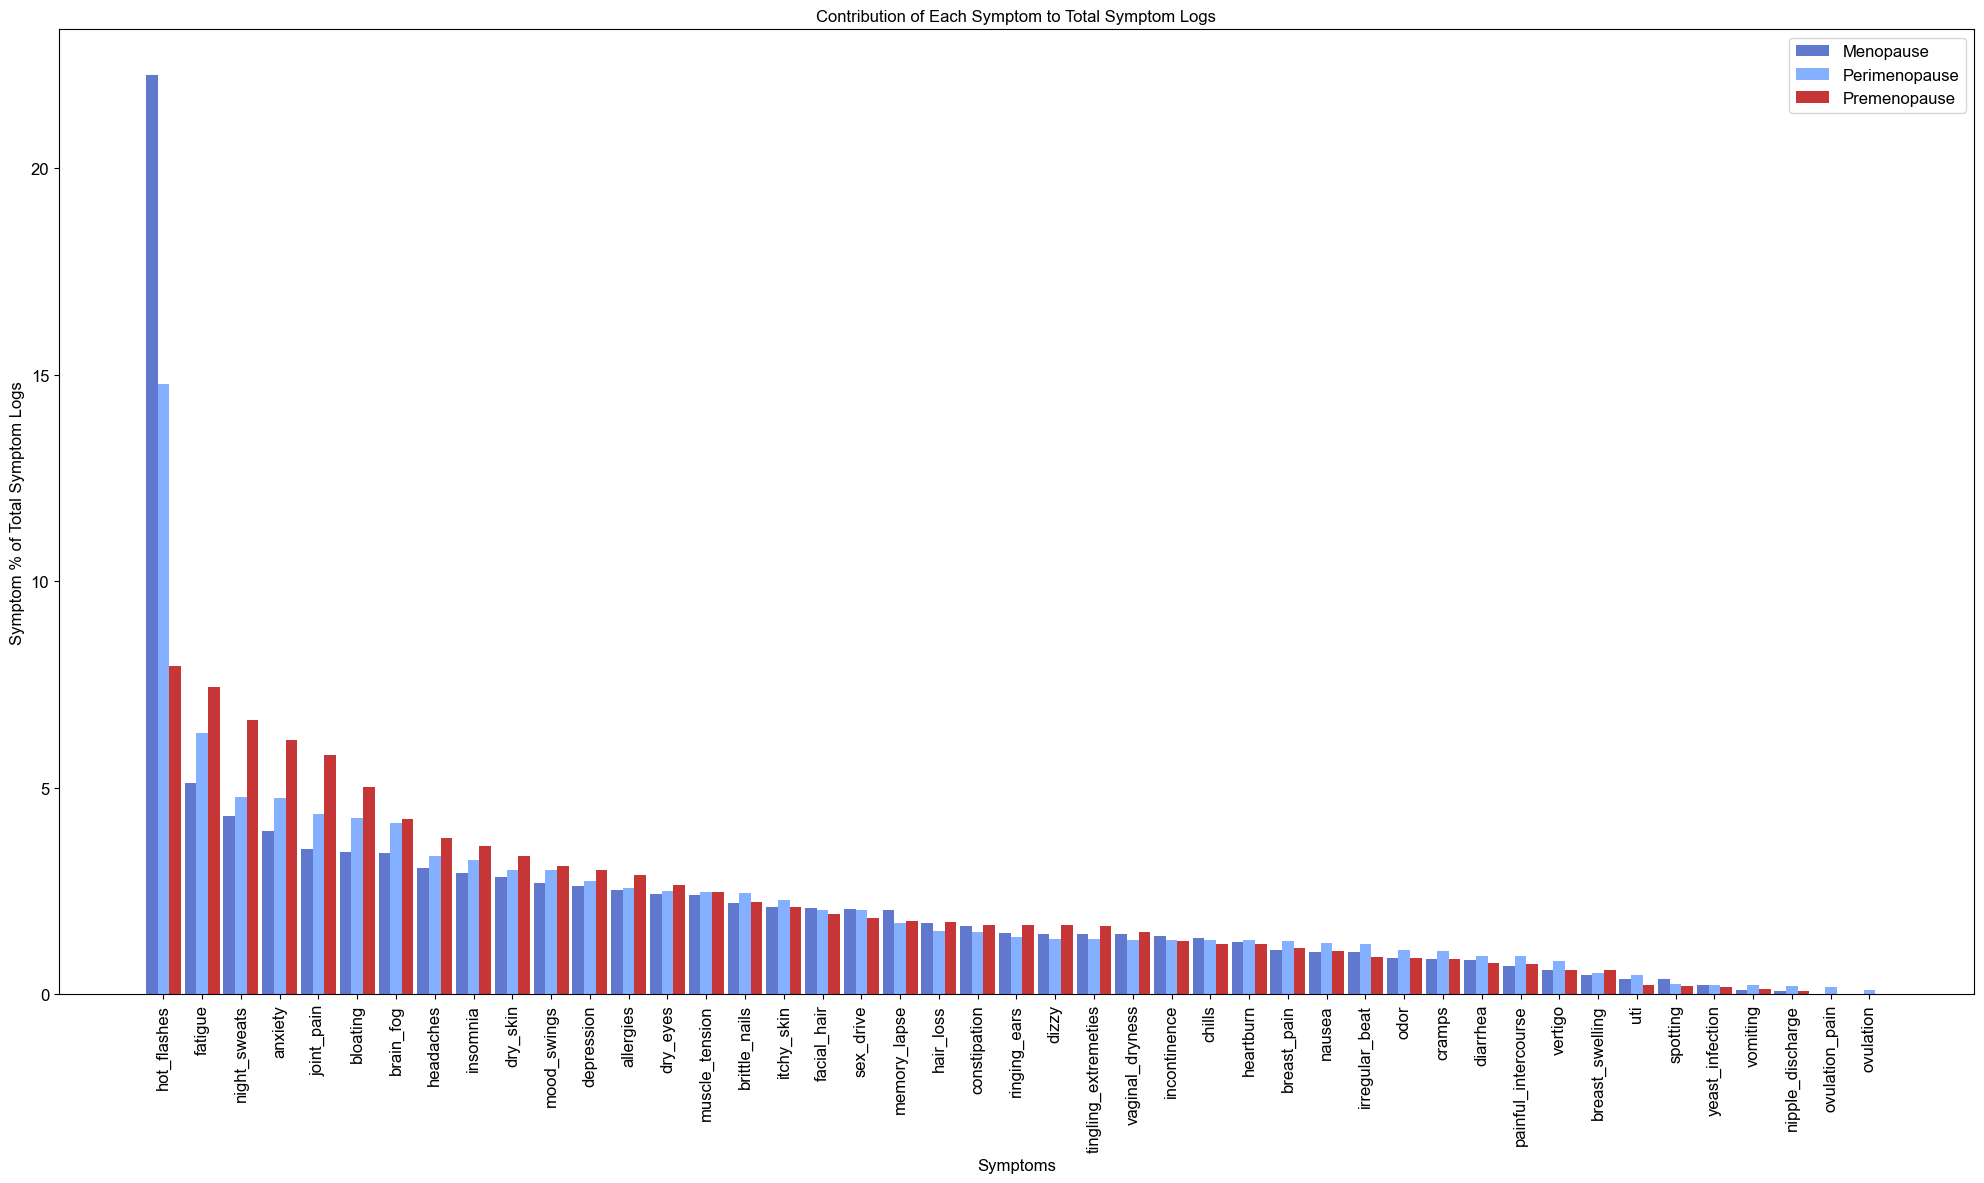

In [48]:
import matplotlib.pyplot as plt
import numpy as np

symptom_percentages_sorted_premenopause = symptom_percentages_premenopause.sort_values(ascending=False)
symptom_percentages_sorted_perimenopause = symptom_percentages_perimenopause.sort_values(ascending=False)
symptom_percentages_sorted_menopause = symptom_percentages_menopause.sort_values(ascending=False)


plt.figure(figsize=(20, 12))  # Set the figure size for better visibility


bar_width = 0.3


# Calculate the positions for each group
r1 = np.arange(len(symptom_percentages_sorted_menopause))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.bar(r1, symptom_percentages_sorted_menopause.values, width=bar_width, alpha=0.7, color=color_menopause, label='Menopause')
plt.bar(r2, symptom_percentages_sorted_perimenopause.values, width=bar_width, alpha=1, color=color_perimenopause, label='Perimenopause')
plt.bar(r3, symptom_percentages_sorted_premenopause.values, width=bar_width, alpha=0.8, color=color_premenopause, label='Premenopause')

plt.xlabel("Symptoms")
plt.ylabel("Symptom % of Total Symptom Logs")
plt.title("Contribution of Each Symptom to Total Symptom Logs")

# Set the position of the x-ticks
plt.xticks([r + bar_width for r in range(len(symptom_percentages_sorted_menopause))], symptom_percentages_sorted_menopause.index, rotation=90)

plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.legend()  # Add a legend

plt.show()


In [49]:
f1 = pd.DataFrame(symptom_percentages_premenopause, columns=['Percentage'])
f1['Symptom Name'] = f1.index
f1['Phase'] = ['Premenopause' for i in range(f1.shape[0])]
print(f1.shape)
f2 = pd.DataFrame(symptom_percentages_perimenopause, columns=['Percentage'])
f2['Symptom Name'] = f2.index
f2['Phase'] = ['Perimenopause' for i in range(f2.shape[0])]
print(f2.shape)
f3 = pd.DataFrame(symptom_percentages_menopause, columns=['Percentage'])
f3['Symptom Name'] = f3.index
f3['Phase'] = ['Menopause' for i in range(f3.shape[0])]
print(f3.shape)

df = pd.concat([f1, f2, f3])
df = df.sort_values(by='Percentage', ascending=False)
print(df.shape)

(45, 3)
(45, 3)
(45, 3)
(135, 3)


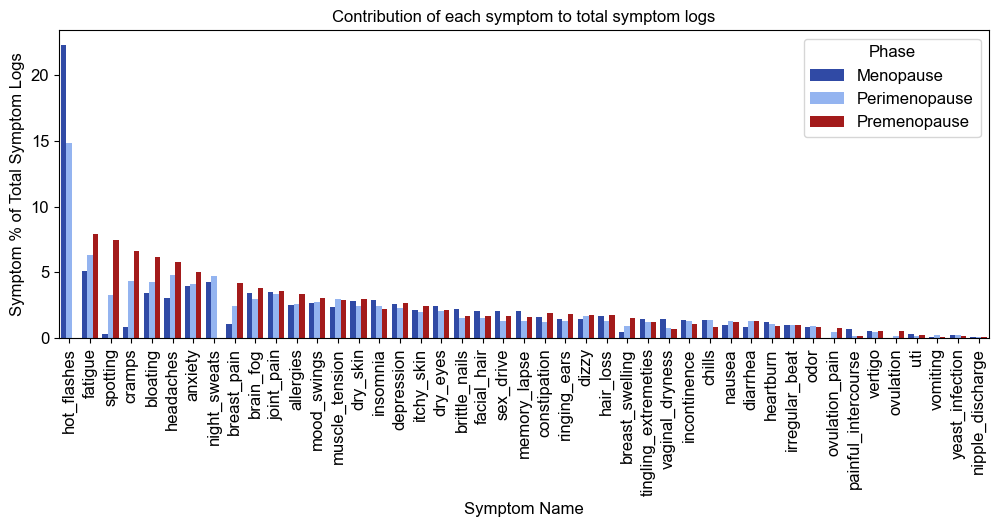

In [50]:
color_palette = {
    'Menopause' : color_menopause,
    'Perimenopause' : color_perimenopause,
    'Premenopause' : color_premenopause
}
#sns.set_palette('coolwarm')
plt.figure(figsize=(12, 4))
sns.barplot(df, x='Symptom Name', y='Percentage', hue='Phase', palette=color_palette, orient='v')
plt.ylabel('Symptom % of Total Symptom Logs')
plt.title('Contribution of each symptom to total symptom logs')
plt.xticks(rotation=90)
plt.savefig('paper_figures/symptom_percentage_total.png')
plt.show()

In [51]:
sns.color_palette()

[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.603162067917647, 0.7315274773529412, 0.9995652785372549),
 (0.7867207013568628, 0.8448072103686275, 0.9398103849490196),
 (0.9306685963333333, 0.818876999654902, 0.7591463906980392),
 (0.9673165156666667, 0.6574708288078431, 0.5381601507294118),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

In [52]:
# Step 1: Calculate the total number of users
total_users_premenopause = len(premenopauseframe)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages_premenopause = (premenopauseframe.astype(bool).sum() / total_users_premenopause) * 100

print(symptom_percentages_premenopause.sort_values(ascending=False))

fatigue                 74.439462
bloating                60.627803
cramps                  57.309417
headaches               52.645740
anxiety                 52.197309
brain_fog               47.443946
joint_pain              42.869955
mood_swings             40.538117
breast_pain             37.130045
dry_skin                36.681614
depression              36.322870
spotting                35.067265
muscle_tension          34.977578
allergies               34.080717
itchy_skin              32.286996
insomnia                29.417040
facial_hair             28.071749
dry_eyes                26.905830
dizzy                   26.278027
hair_loss               25.650224
constipation            24.394619
sex_drive               24.035874
brittle_nails           23.946188
memory_lapse            23.677130
tingling_extremeties    20.448430
ringing_ears            19.551570
diarrhea                19.551570
nausea                  18.834081
breast_swelling         17.219731
incontinence  

In [53]:
# Step 1: Calculate the total number of users
total_users_perimenopause = len(perimenopauseframe)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages_perimenopause = (perimenopauseframe.astype(bool).sum() / total_users_perimenopause) * 100

print(symptom_percentages_perimenopause.sort_values(ascending=False))

hot_flashes             83.357349
fatigue                 74.783862
night_sweats            62.175793
headaches               58.933718
bloating                57.132565
cramps                  54.899135
anxiety                 53.314121
brain_fog               51.224784
joint_pain              48.342939
mood_swings             46.829971
insomnia                45.965418
dry_skin                40.850144
muscle_tension          40.201729
depression              39.121037
itchy_skin              38.976945
allergies               37.824207
breast_pain             34.221902
spotting                33.645533
facial_hair             33.429395
memory_lapse            32.564841
brittle_nails           31.051873
dry_eyes                30.763689
dizzy                   30.691643
sex_drive               29.106628
nausea                  26.945245
hair_loss               26.873199
constipation            26.729107
tingling_extremeties    25.648415
chills                  25.360231
diarrhea      

In [54]:
# Step 1: Calculate the total number of users
total_users_menopause = len(menopauseframe)

# Step 2: Calculate the percentage of users who have each symptom
symptom_percentages_menopause = (menopauseframe.astype(bool).sum() / total_users_menopause) * 100

print(symptom_percentages_menopause.sort_values(ascending=False))

fatigue                 74.978128
hot_flashes             73.097113
anxiety                 58.748906
joint_pain              56.124234
brain_fog               56.124234
night_sweats            53.280840
bloating                52.405949
insomnia                52.055993
mood_swings             49.037620
headaches               48.862642
dry_skin                47.462817
depression              47.112861
memory_lapse            43.000875
sex_drive               41.557305
muscle_tension          40.682415
itchy_skin              39.238845
brittle_nails           38.976378
facial_hair             37.051619
allergies               36.789151
dry_eyes                35.389326
hair_loss               34.820647
constipation            32.370954
tingling_extremeties    28.958880
vaginal_dryness         27.996500
dizzy                   27.121610
incontinence            24.759405
ringing_ears            24.759405
heartburn               23.490814
irregular_beat          20.822397
chills        

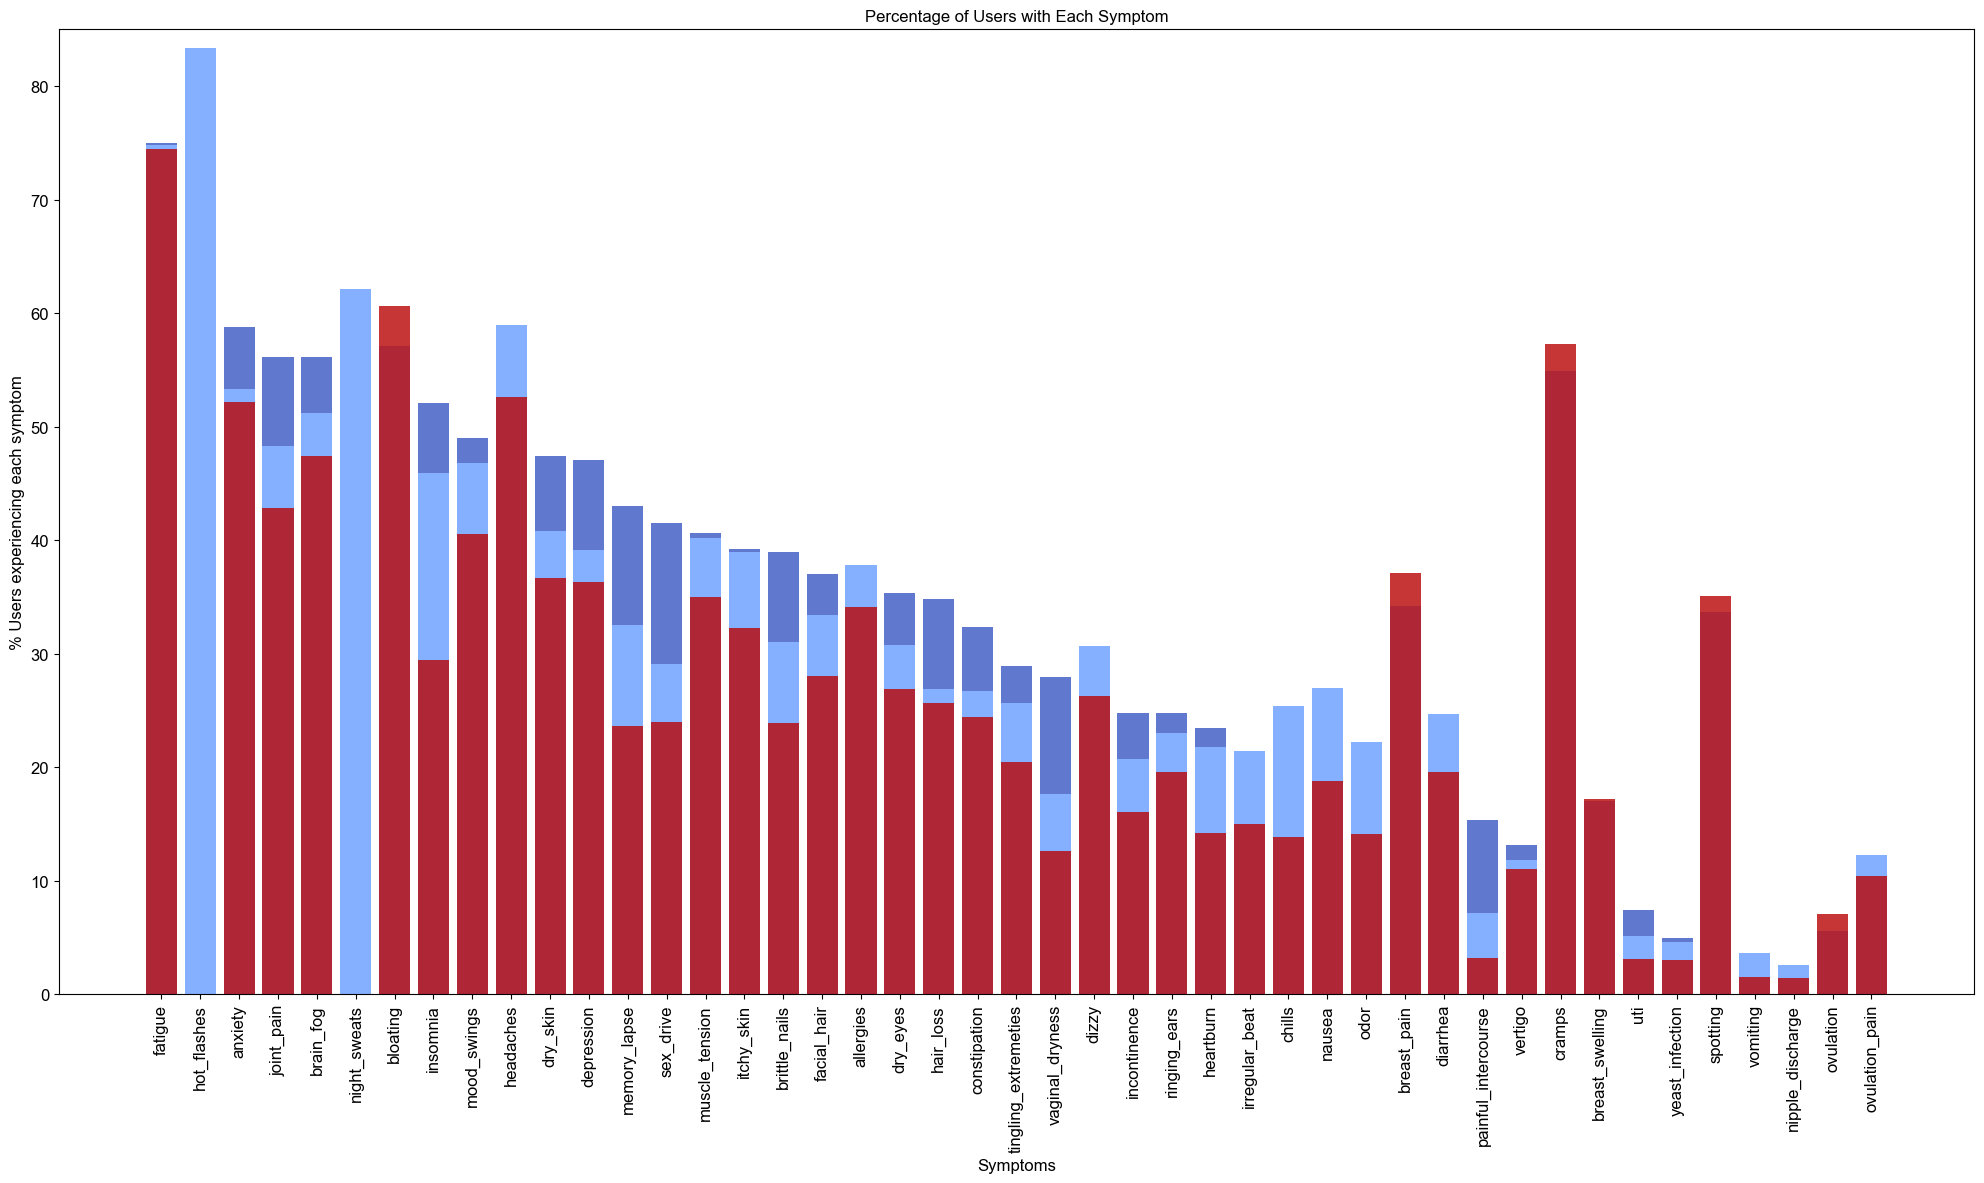

In [55]:
symptom_percentages_sorted_premenopause = symptom_percentages_premenopause.sort_values(ascending=False)
symptom_percentages_sorted_perimenopause = symptom_percentages_perimenopause.sort_values(ascending=False)
symptom_percentages_sorted_menopause = symptom_percentages_menopause.sort_values(ascending=False)

plt.figure(figsize=(20, 12))  # Set the figure size for better visibility
plt.bar(symptom_percentages_sorted_menopause.index, symptom_percentages_sorted_menopause.values,alpha=0.7, color=color_menopause)

plt.bar(symptom_percentages_sorted_perimenopause.index, symptom_percentages_sorted_perimenopause.values,alpha=1,color=color_perimenopause)

plt.bar(symptom_percentages_sorted_premenopause.index, symptom_percentages_sorted_premenopause.values,alpha=0.8,color=color_premenopause)


plt.xlabel("Symptoms")
plt.ylabel("% Users experiencing each symptom")
plt.ylim(0,85)
plt.title("Percentage of Users with Each Symptom")
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.show()

In [56]:
f1 = pd.DataFrame(symptom_percentages_sorted_premenopause, columns=['Percentage'])
f1['Symptom Name'] = f1.index
f1['Phase'] = ['Premenopause' for i in range(f1.shape[0])]
print(f1.shape)
f2 = pd.DataFrame(symptom_percentages_sorted_perimenopause, columns=['Percentage'])
f2['Symptom Name'] = f2.index
f2['Phase'] = ['Perimenopause' for i in range(f2.shape[0])]
print(f2.shape)
f3 = pd.DataFrame(symptom_percentages_sorted_menopause, columns=['Percentage'])
f3['Symptom Name'] = f3.index
f3['Phase'] = ['Menopause' for i in range(f3.shape[0])]
print(f3.shape)

df = pd.concat([f1, f2, f3])
df = df.sort_values(by='Percentage', ascending=False)
print(df.shape)

(45, 3)
(45, 3)
(45, 3)
(135, 3)


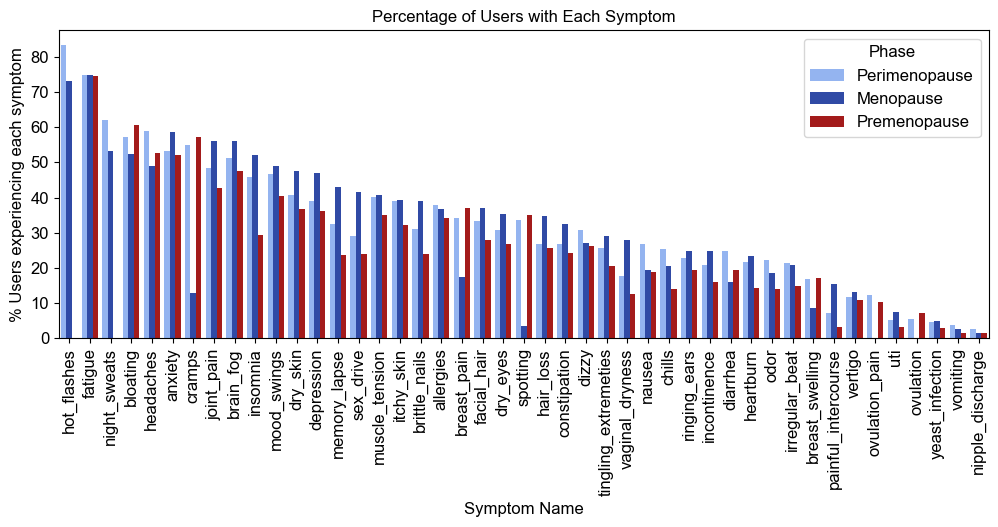

In [57]:
color_palette = {
    'Menopause' : color_menopause,
    'Perimenopause' : color_perimenopause,
    'Premenopause' : color_premenopause
}
#sns.set_palette('coolwarm')
plt.figure(figsize=(12, 4))
sns.barplot(df, x='Symptom Name', y='Percentage', hue='Phase', palette=color_palette, orient='v')
plt.ylabel('% Users experiencing each symptom')
plt.title('Percentage of Users with Each Symptom')
plt.xticks(rotation=90)
#plt.savefig('paper_figures/symptom_percentage_total.png')
plt.show()

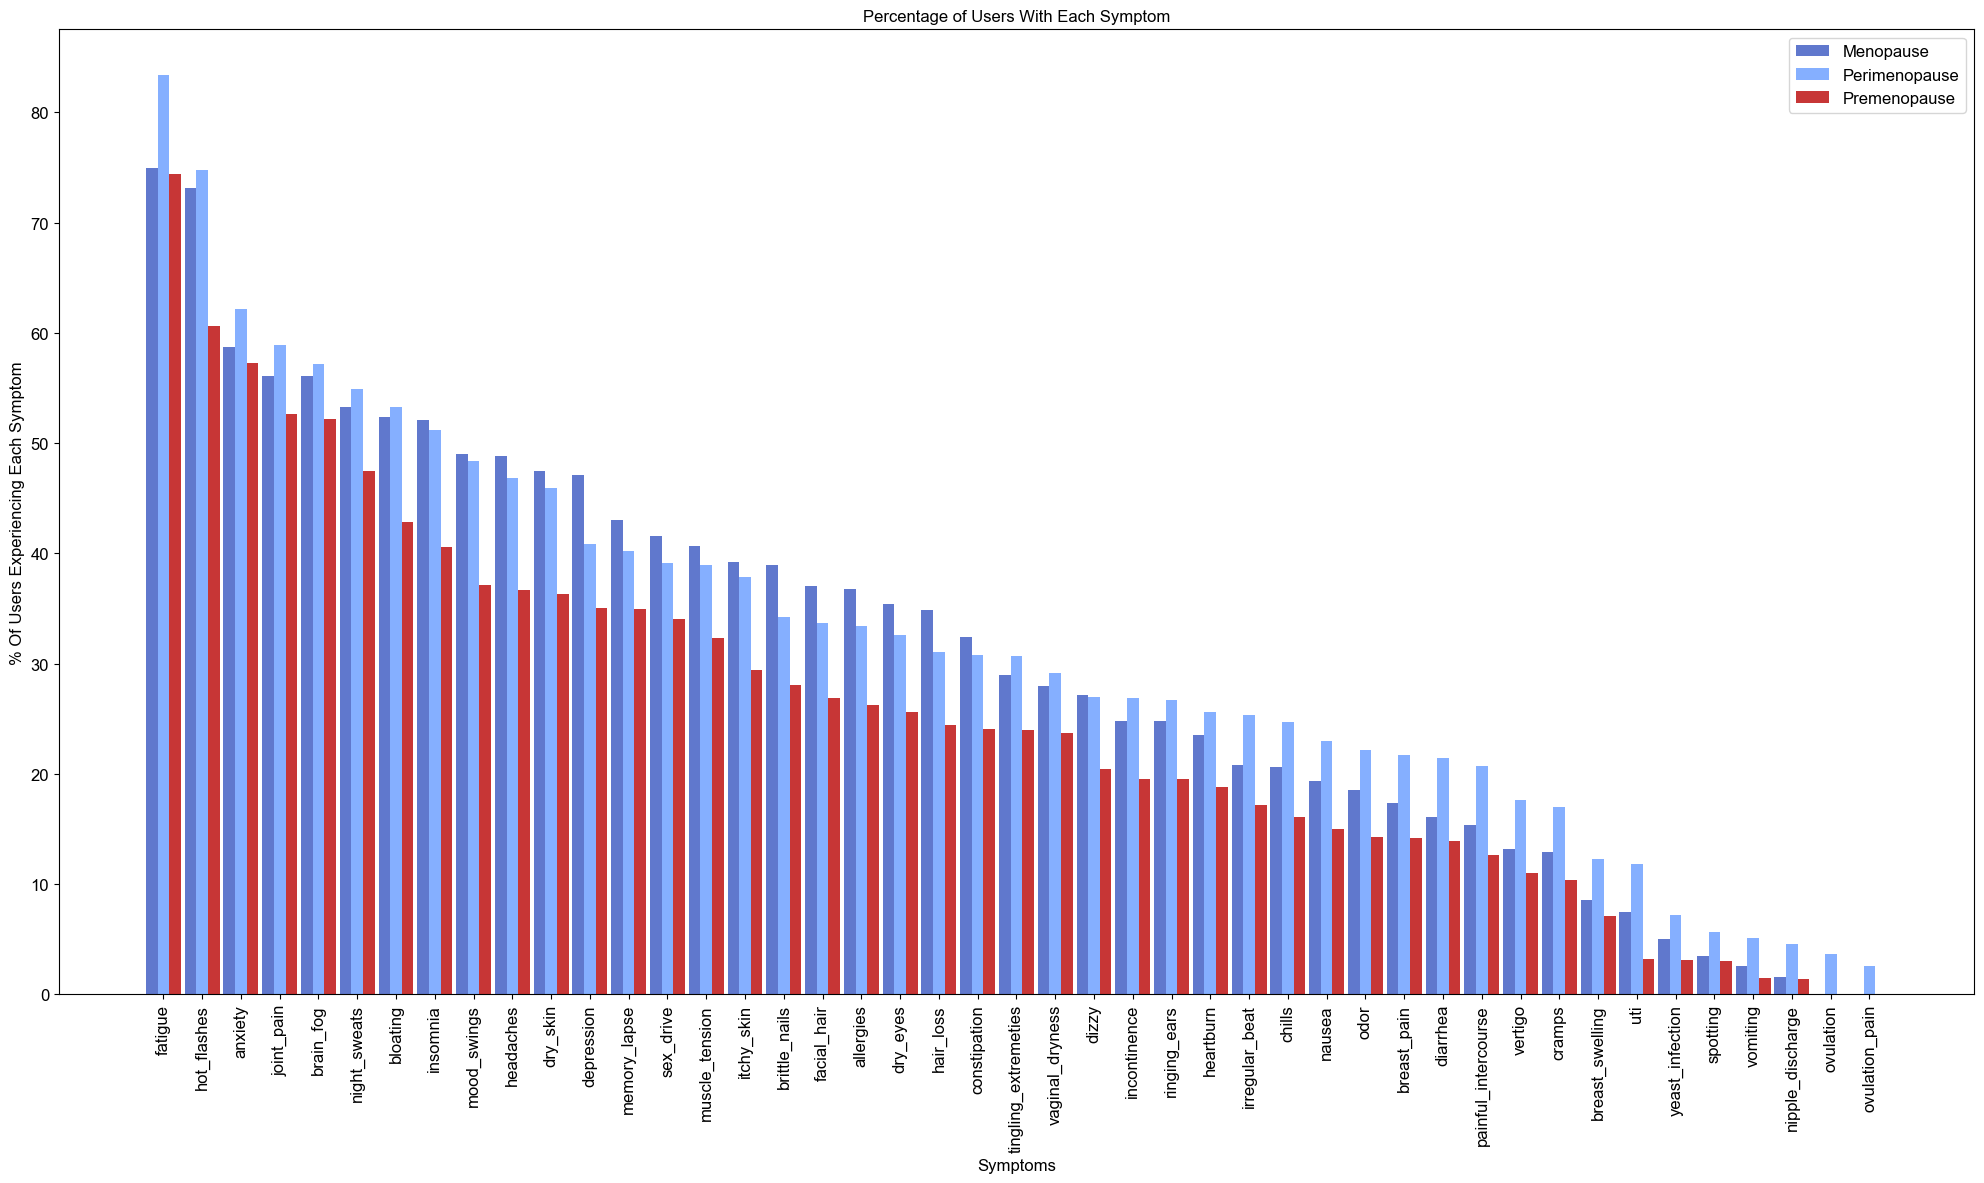

In [58]:
import matplotlib.pyplot as plt
import numpy as np

symptom_percentages_sorted_premenopause = symptom_percentages_premenopause.sort_values(ascending=False)
symptom_percentages_sorted_perimenopause = symptom_percentages_perimenopause.sort_values(ascending=False)
symptom_percentages_sorted_menopause = symptom_percentages_menopause.sort_values(ascending=False)


plt.figure(figsize=(20, 12))  # Set the figure size for better visibility


bar_width = 0.3


# Calculate the positions for each group
r1 = np.arange(len(symptom_percentages_sorted_menopause))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.bar(r1, symptom_percentages_sorted_menopause.values, width=bar_width, alpha=0.7, color=color_menopause, label='Menopause')
plt.bar(r2, symptom_percentages_sorted_perimenopause.values, width=bar_width, alpha=1, color=color_perimenopause, label='Perimenopause')
plt.bar(r3, symptom_percentages_sorted_premenopause.values, width=bar_width, alpha=0.8, color=color_premenopause, label='Premenopause')

plt.xlabel("Symptoms")
plt.ylabel("% Of Users Experiencing Each Symptom")
plt.title("Percentage of Users With Each Symptom")

# Set the position of the x-ticks
plt.xticks([r + bar_width for r in range(len(symptom_percentages_sorted_menopause))], symptom_percentages_sorted_menopause.index, rotation=90)

plt.tight_layout()  # Adjust the layout to prevent cropping of labels
plt.legend()  # Add a legend

plt.show()


## Covariance matrix of the features

Standardize the features first.

In [59]:
sframe = frame[symptoms].astype('int64')
sframe = (sframe - sframe.mean()) / sframe.std()

### Visualizing the KDES of some of the symptoms

Hotflashes

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


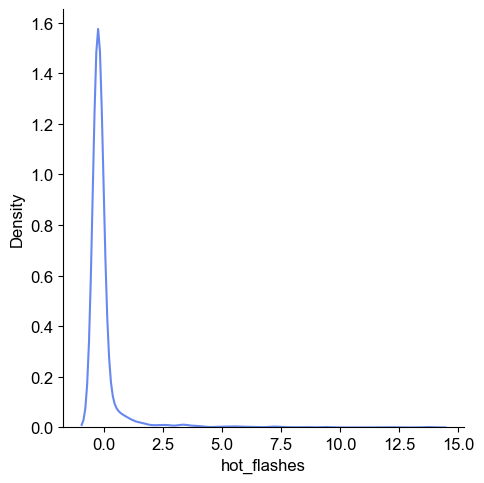

In [60]:
sns.displot(sframe, x='hot_flashes', kind='kde')

/home/ubuntu/anaconda3/envs/menolife/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


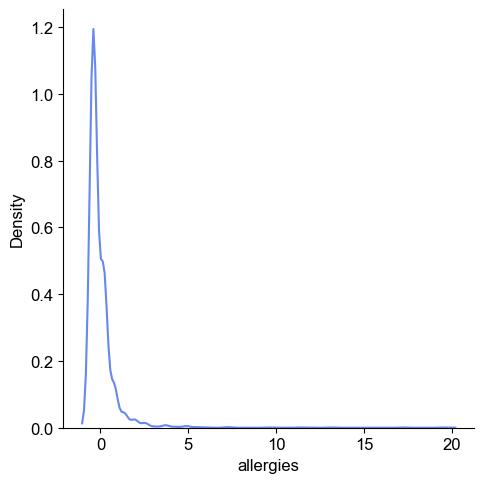

In [61]:
sns.displot(sframe, x='allergies', kind='kde')

In [62]:
cmatrix = sframe.cov()

In [63]:
#cmatrix = sframe_by_symptom.cov()

# List of symptom names to remove
symptoms_to_remove = ["ovulation", "ovulation_pain"]

# Step 1: Drop the specified rows and columns from the covariance matrix
cmatrix = cmatrix.drop(symptoms_to_remove, axis=0).drop(symptoms_to_remove, axis=1)

# Step 2: Print the filtered covariance matrix
#print(filtered_cmatrix)


In [64]:
cmatrix.to_csv('menopause_symptom_npt_covariance.csv', index=True)

In [65]:
fig = px.imshow(cmatrix, 
                width=2000, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
# Also go ahead and save this figure.
#fig.write_image('menopause_symptom_npt_covariance.png')

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.

### Find pairs of symptoms with more than 60% corelation.

In [66]:
th = 0.4
fmatrix = cmatrix[cmatrix >= th]
fig = px.imshow(fmatrix, 
                width=1024, 
                height=1024, 
                text_auto=True, 
                aspect='auto',
                title='Symptom Covariance')
fig.show()
indexes = fmatrix.index.values
for s in symptoms:
    if s not in ['ovulation', 'ovulation_pain']:  # Exclude 'hot_flashes' and 'night_sweats' from iteration
        paired = fmatrix[s].dropna().index.values
        # We can go ahead and print it out.
        for p in paired:
            if not (s == p):
                print('{} - {} - {}'.format(s, p, fmatrix.loc[s][p]))

anxiety - depression - 0.444640825821124
brain_fog - fatigue - 0.4973623246047882
brain_fog - memory_lapse - 0.496311062768582
brittle_nails - dry_skin - 0.46704958073484826
chills - irregular_beat - 0.4535375495150016
depression - anxiety - 0.444640825821124
dry_eyes - dry_skin - 0.5019403590433281
dry_skin - brittle_nails - 0.46704958073484826
dry_skin - dry_eyes - 0.5019403590433281
dry_skin - itchy_skin - 0.4388091741193365
facial_hair - itchy_skin - 0.4969249466142075
facial_hair - vaginal_dryness - 0.4612143972510855
fatigue - brain_fog - 0.4973623246047882
fatigue - headaches - 0.42646234885074186
headaches - fatigue - 0.42646234885074186
irregular_beat - chills - 0.4535375495150016
itchy_skin - dry_skin - 0.4388091741193365
itchy_skin - facial_hair - 0.4969249466142075
itchy_skin - vaginal_dryness - 0.46522064534945634
joint_pain - muscle_tension - 0.4280727330568861
memory_lapse - brain_fog - 0.496311062768582
memory_lapse - muscle_tension - 0.4096439211338576
muscle_tension -

## Cluster Map

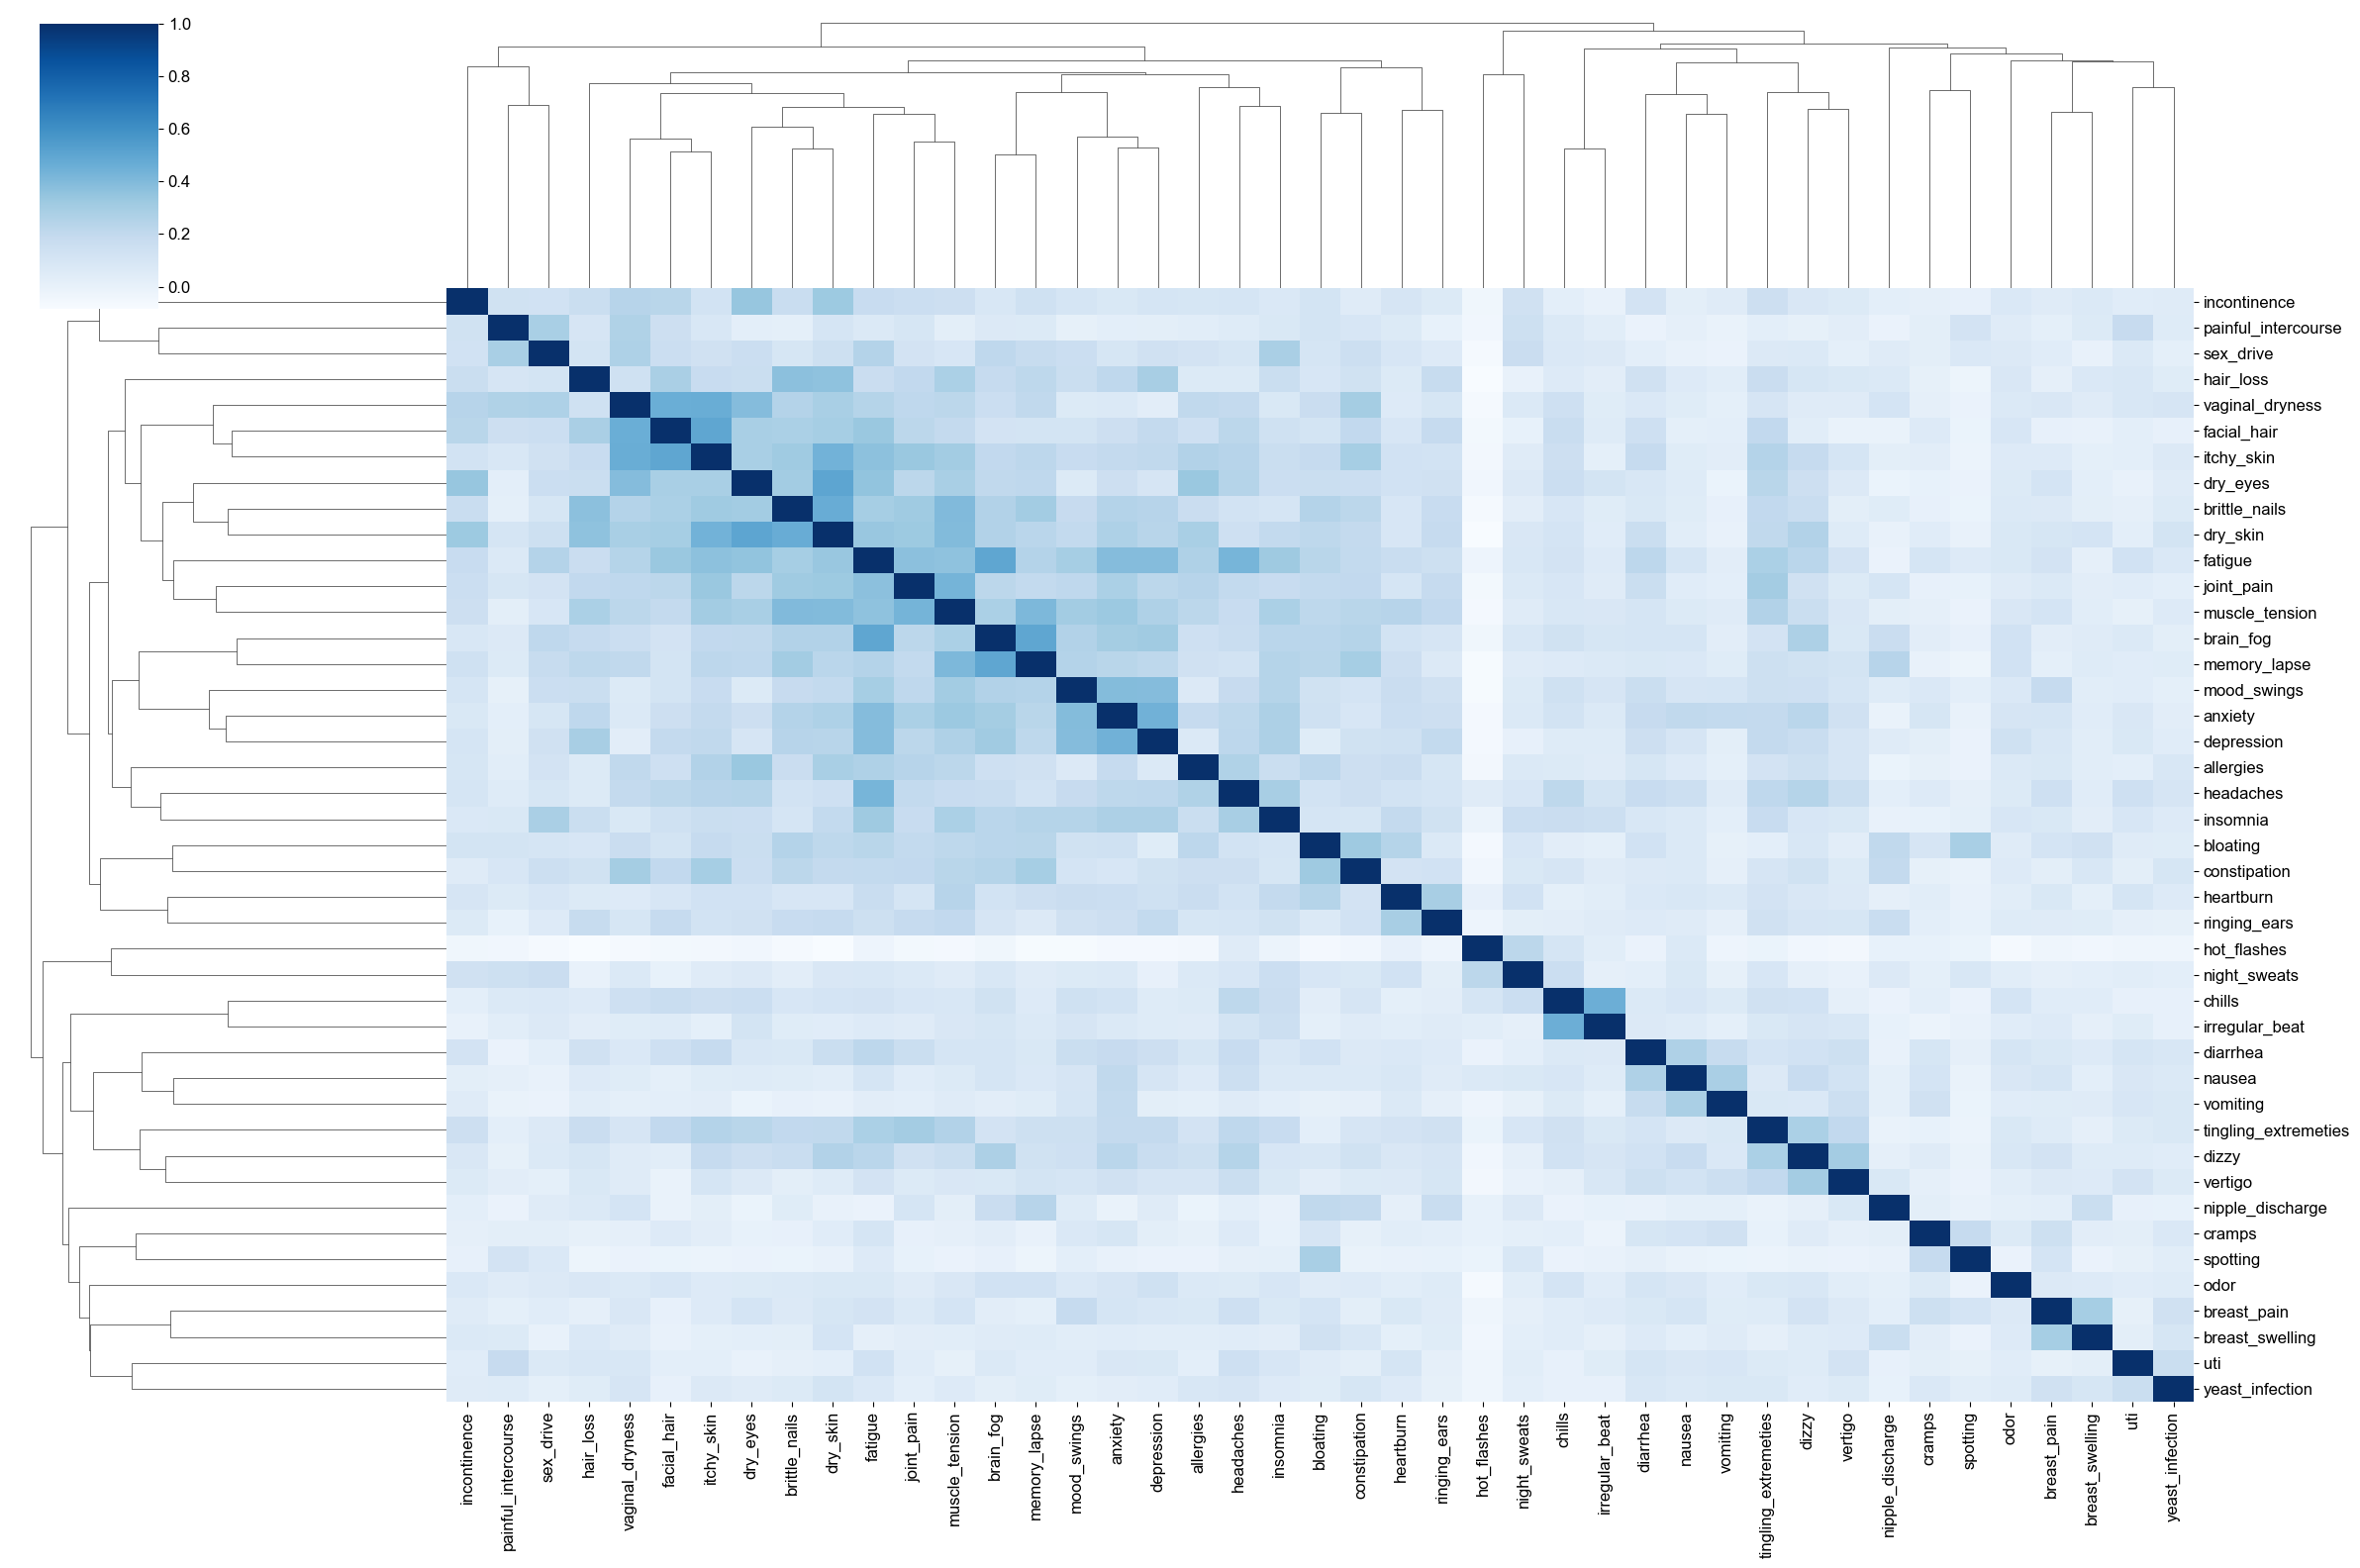

In [67]:
hcluster = sns.clustermap(cmatrix, figsize=(24, 16), cmap="Blues")

In [68]:
hcluster.savefig('symptom_co_hirach_menopausal_blues_npt.png')

In [69]:
#Let's use silhouette score instead here. 
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import seaborn as sns

# Get the cluster assignments from the Seaborn plot
cluster_assignments = hcluster.dendrogram_row.reordered_ind

# Convert the cluster assignments to a NumPy array
cluster_assignments = np.array(cluster_assignments)

# Calculate the silhouette scores for different numbers of clusters
max_clusters = 10  # Set a reasonable maximum number of clusters to consider
silhouette_scores = []

for num_clusters in range(2, max_clusters + 1):
    # Perform hierarchical clustering with 'num_clusters'
    cluster_model = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_model.fit(cmatrix)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(cmatrix, cluster_model.labels_)
    silhouette_scores.append(score)

# Find the optimal number of clusters that maximizes the silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # Adding 2 because range starts from 2

print("Optimal number of clusters:", optimal_num_clusters)

Optimal number of clusters: 2


## Perform PCA analysis on the data.

In [70]:
from sklearn.decomposition import PCA

In [71]:
pca = PCA(n_components=15, svd_solver='full')
X = frame[symptoms]

In [72]:
pca.fit(X)

PCA(n_components=15, svd_solver='full')

In [75]:
evariance = pca.explained_variance_ratio_
cvariance = np.cumsum(evariance)

The variance from the various features is -

In [76]:
for i,v,c in zip(range(1, evariance.size+1), evariance, cvariance):
    print('PCA{} - {:.2f}, {:.2f}'.format(i, v, c))

PCA1 - 0.86, 0.86
PCA2 - 0.03, 0.89
PCA3 - 0.02, 0.91
PCA4 - 0.01, 0.92
PCA5 - 0.01, 0.92
PCA6 - 0.01, 0.93
PCA7 - 0.01, 0.94
PCA8 - 0.00, 0.94
PCA9 - 0.00, 0.94
PCA10 - 0.00, 0.95
PCA11 - 0.00, 0.95
PCA12 - 0.00, 0.96
PCA13 - 0.00, 0.96
PCA14 - 0.00, 0.96
PCA15 - 0.00, 0.97


Looks like we would need just 3 principal components if we wanted to keep 90% of the variance. \
However the 2 components account for the majority of variance (89%).

In [77]:
pcacomponents = pca.fit_transform(X)

In [78]:
pcacomponents.shape

(2286, 15)

In [53]:
# Get the impact of each feature on principal component.
impact = pca.components_.T
impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

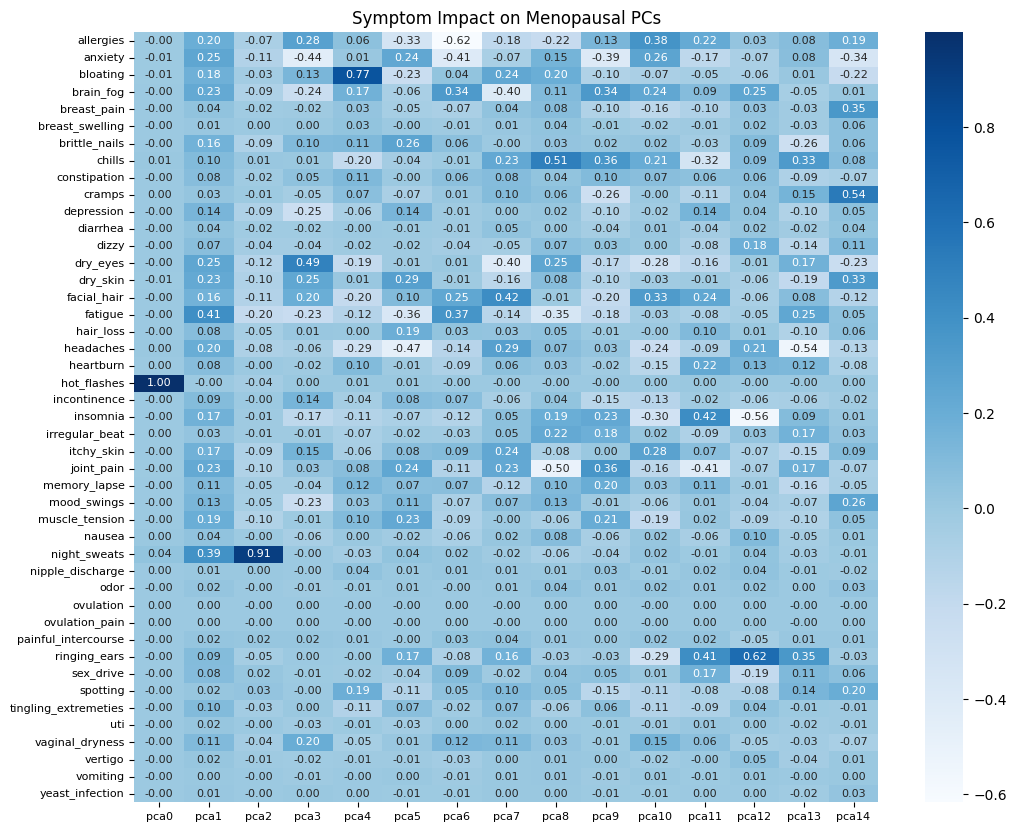

In [54]:
#Alt plot that shows every row label

import matplotlib.pyplot as plt
import seaborn as sns

# Create a light palette with the color 'seagreen'
cmap=sns.color_palette("Blues", as_cmap=True)

# Assuming you already have the impact DataFrame 'impact' from your code
# impact = pd.DataFrame(impact, index=symptoms, columns=pca.get_feature_names_out())

# Create a heatmap using the custom colormap
plt.figure(figsize=(12, 10))
sns.heatmap(impact, cmap=cmap, annot=True, fmt=".2f", annot_kws={"size": 8})

# Adjust the font size of x-axis and y-axis tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Set the title and adjust its font size
plt.title('Symptom Impact on Menopausal PCs', fontsize=12)

plt.show()

For the clustering we just pick the components that give 90% variance

In [56]:
pca = PCA(n_components=3, svd_solver='full')
pcacomponents = pca.fit_transform(X)
pcacomponents.shape

(2286, 3)

In [57]:
from sklearn.cluster import KMeans

## Determining the optimal cluster size.

### Elbow Method

In [58]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    sse.append(kmeans.inertia_)

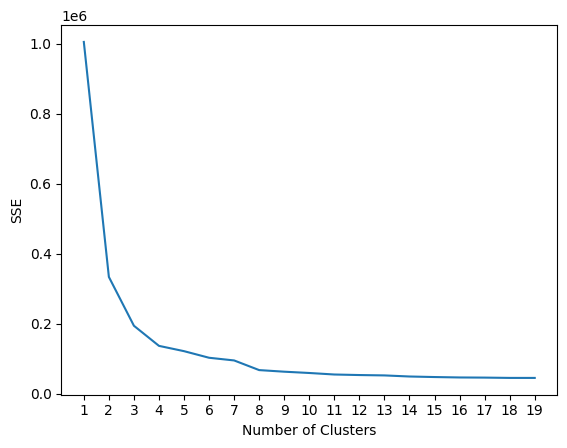

In [59]:
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [61]:
from kneed import KneeLocator

kl = KneeLocator(
    range(1, 20), sse, curve="convex", direction="decreasing"
)

kl.knee

4

Conclusion - Based on the elbow method, it looks like the optimal number of clusters would be **4**

### Silhouette Coefficient

Is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
* How close the data point is to other points in the cluster
* How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In [62]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcacomponents)
    score = silhouette_score(pcacomponents, kmeans.labels_)
    silhouette_coefficients.append(score)

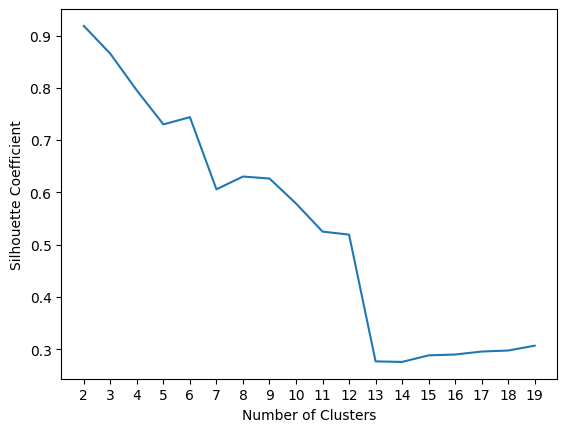

In [63]:
plt.plot(range(2, 20), silhouette_coefficients)
plt.xticks(range(2, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Conclusion - From silhouette coeff it looks like the score is maximized for n=6. We will pick n=6 based on the elbow method + S method.

## Cluster them using k-means clustering

In [65]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(pcacomponents)
labels = kmeans.labels_
unq = np.unique(labels)
for u in unq:
    print('{} - {}'.format(u, np.argwhere(labels == u).size))

0 - 49
1 - 137
2 - 16
3 - 2084


### Get the users which belong to each of these clusters

In [66]:
user_segments = [[] for i in range(0, unq.size)]

for (i, uid) in enumerate(X.index.values):
    user_segments[labels[i]] += [uid]

### Find the top 10 symptoms reported by frequency for each of these segments.

In [67]:
def getTopSymptoms(users, top=10):
    # Create the where statement that will be used to filter by these users.
    where_query = "uid = '{}'".format(users[0])
    for i in range(1, len(users)):
        where_query += " or uid = '{}'".format(users[i])
        
    query = """
        select name, count(name) occ from symptoms 
            where {where}
            group by name
            order by occ desc
            limit {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    
    return results

In [68]:
## If the block above throws an error - use this. 
def getTopSymptoms(users, top=10):
    if len(users) == 0:
        return pd.DataFrame(columns=['name', 'occ'])  # Return an empty DataFrame if no users in the segment
    
    where_query = "uid IN ('{}')".format("','".join(users))
    
    query = """
        SELECT name, COUNT(name) AS occ FROM symptoms 
        WHERE {where}
        GROUP BY name
        ORDER BY occ DESC
        LIMIT {top}
    """.format(where=where_query, top=top)
    
    results = db.execQuery(query, cached=True)
    return results


In [ ]:
segments = [[] for i in range(0, unq.size)]

for (i, segment) in enumerate(user_segments):
    result = getTopSymptoms(segment)
    segments[i] = result['name'].values

In [71]:
for (i,s) in enumerate(segments):
    print('Segment {}'.format(i))
    print(s)

Segment 0
['hot_flashes' 'night_sweats' 'chills' 'headaches' 'irregular_beat'
 'fatigue' 'tingling_extremeties' 'anxiety' 'nausea' 'insomnia']
Segment 1
['hot_flashes' 'night_sweats' 'fatigue' 'brain_fog' 'bloating' 'insomnia'
 'headaches' 'anxiety' 'joint_pain' 'sex_drive']
Segment 2
['hot_flashes' 'night_sweats' 'headaches' 'insomnia' 'fatigue' 'nausea'
 'chills' 'depression' 'joint_pain' 'constipation']
Segment 3
['hot_flashes' 'fatigue' 'anxiety' 'joint_pain' 'bloating' 'brain_fog'
 'night_sweats' 'headaches' 'dry_skin' 'insomnia']


Summary of cohort symptoms -

PCA + Clustering was able to isolate the users into 4 clusters based on the occurance of their symptom reporting.a

### Notes

1. I find it interesting that covariance of all other features with Hotflahses is extremely low, except for Nightsweats. Could this mean that an increasing number of hotflash reporting is associated with an increasein the number of nightsweats reporting.